# Descartes Underwriting - Take Home Test

#### Imports

In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier

import sklearn
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, f1_score, recall_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

%matplotlib inline
sns.set()
sns.color_palette("cubehelix", as_cmap=True)
warnings.filterwarnings("ignore")

## Data

#### Data imports and general study

In [3]:
cd downloads

/Users/mouniaelbaz/Downloads


In [4]:
TRAIN_PATH = 'train_auto.csv'
TEST_PATH  = 'test_auto.csv'

In [5]:
data=pd.read_csv(TRAIN_PATH, index_col='INDEX')
data_test=pd.read_csv(TEST_PATH, index_col='INDEX')
data.head()

,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
INDEX,,,,,,,,,,,,,,,,,,,,,
1,0,0.0,0,60.0,0,11.0,"$67,349",No,$0,z_No,...,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
2,0,0.0,0,43.0,0,11.0,"$91,449",No,"$257,252",z_No,...,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
4,0,0.0,0,35.0,1,10.0,"$16,039",No,"$124,191",Yes,...,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
5,0,0.0,0,51.0,0,14.0,NaN,No,"$306,251",Yes,...,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
6,0,0.0,0,50.0,0,NaN,"$114,986",No,"$243,925",Yes,...,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban


In [6]:
data.info()
print('Number of Features = {}, Number of Observations = {}'.format(len(data.columns)-2,len(data)))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8161 entries, 1 to 10302
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   TARGET_FLAG  8161 non-null   int64  
 1   TARGET_AMT   8161 non-null   float64
 2   KIDSDRIV     8161 non-null   int64  
 3   AGE          8155 non-null   float64
 4   HOMEKIDS     8161 non-null   int64  
 5   YOJ          7707 non-null   float64
 6   INCOME       7716 non-null   object 
 7   PARENT1      8161 non-null   object 
 8   HOME_VAL     7697 non-null   object 
 9   MSTATUS      8161 non-null   object 
 10  SEX          8161 non-null   object 
 11  EDUCATION    8161 non-null   object 
 12  JOB          7635 non-null   object 
 13  TRAVTIME     8161 non-null   int64  
 14  CAR_USE      8161 non-null   object 
 15  BLUEBOOK     8161 non-null   object 
 16  TIF          8161 non-null   int64  
 17  CAR_TYPE     8161 non-null   object 
 18  RED_CAR      8161 non-null   object 
 19  OLDCL

In [7]:
#### some light preprocessing before studying the data 

#converting financial values to float
cols = ['INCOME', 'HOME_VAL', 'BLUEBOOK', 'OLDCLAIM']
data[cols] = data[cols].replace({'\$': '', ',': ''}, regex=True).astype(float)
data_test[cols] = data_test[cols].replace({'\$': '', ',': ''}, regex=True).astype(float)



#converting continuous data into type float
data['TIF']=data['TIF'].astype(float)
data_test['TIF']=data_test['TIF'].astype(float)

data['TRAVTIME']=data['TRAVTIME'].astype(float)
data_test['TRAVTIME']=data_test['TRAVTIME'].astype(float)



df=data.iloc[:,2:]

cols_cont = df.loc[:,df.dtypes == float]
print('Continuous features are : {}'.format(list(cols_cont.columns)))

cols_cat = df.loc[:,df.dtypes == int] + data.loc[:,data.dtypes == object]
print('Categorical features are : {}'.format(list(cols_cat.columns)))

Continuous features are : ['AGE', 'YOJ', 'INCOME', 'HOME_VAL', 'TRAVTIME', 'BLUEBOOK', 'TIF', 'OLDCLAIM', 'CAR_AGE']
Categorical features are : ['CAR_TYPE', 'CAR_USE', 'CLM_FREQ', 'EDUCATION', 'HOMEKIDS', 'JOB', 'KIDSDRIV', 'MSTATUS', 'MVR_PTS', 'PARENT1', 'RED_CAR', 'REVOKED', 'SEX', 'URBANICITY']


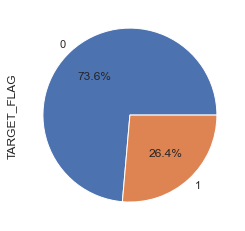

In [8]:
#### Are the target categories balanced ? 
data['TARGET_FLAG'].value_counts().plot(kind='pie', autopct='%.1f%%');

The categories in the training set are clearly unbalanced with the '0' class representing roughly 3/4 of all training data. This should be taken into consideration in training and validation (a validation accuracy around 74% does not indicate a good performance in our case)

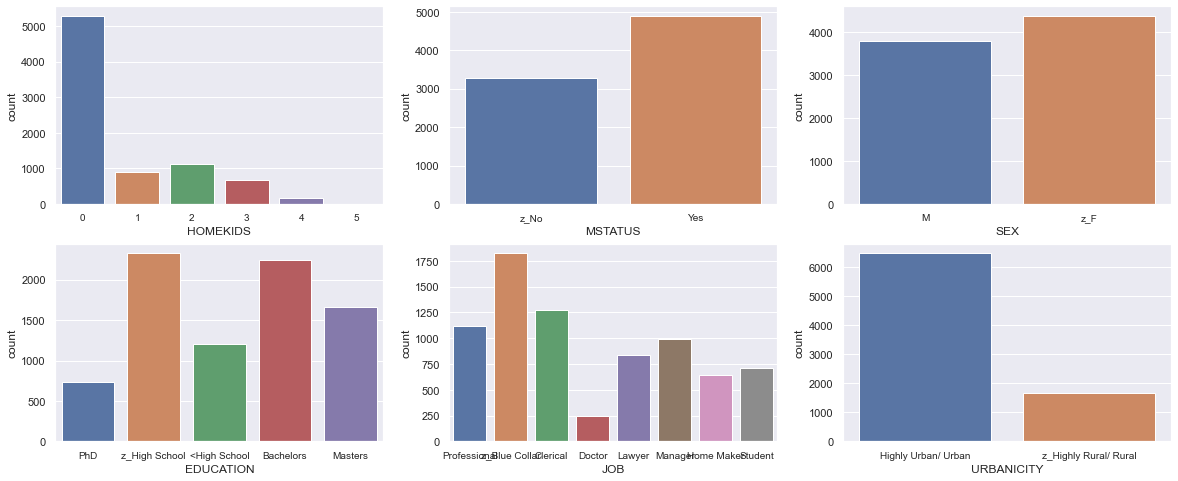

In [9]:
### some categorical features directly related to the subjects
l=['HOMEKIDS',
 'MSTATUS',
 'SEX',
 'EDUCATION',
 'JOB',
 'URBANICITY']

fig, ax = plt.subplots(2,int(len(l)/2), figsize=(20,8))
ax = ax.ravel()

for i, col in enumerate(l):
    sns.countplot(x=col, data=data, ax=ax[i] )
    ax[i].tick_params(axis="x", labelsize=10) 

Most of the subjects are married, have no kids, completed their high school or bachelors, work a blue collar, clerical or 'professional' job and live in highly urban or urban regions. There are also more female subjects but the difference is not significant (10% more females approximately). 

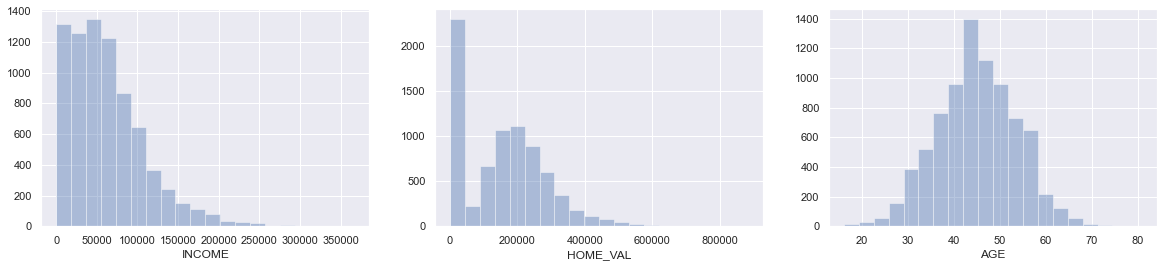

In [10]:
# some continuous features, directly related to the subjects
l=['INCOME',
 'HOME_VAL', 
  'AGE']

fig, ax = plt.subplots(1,len(l), figsize=(20,4))
ax = ax.ravel()

for i, col in enumerate(l):
    sns.distplot(data[col],kde=False, ax=ax[i], bins=20)

Most subejcts do not have any income/own a home. For those who do, the average income seems to follow a skewed normal distribution whose average around 60k while the average home value is around 200k. Subejcts are likely to be between the ages of 40 to 50.

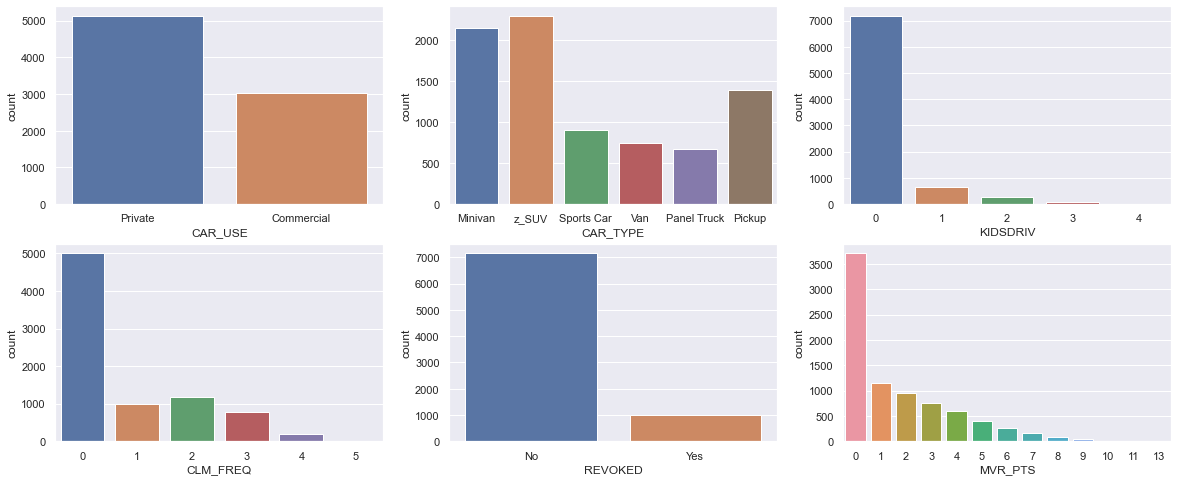

In [11]:
### some categorical features directly related to the car/insurance
l=['CAR_USE',
 'CAR_TYPE',
 'KIDSDRIV',
 'CLM_FREQ',
 'REVOKED',
 'MVR_PTS']

fig, ax = plt.subplots(2,int(len(l)/2), figsize=(20,8))
ax = ax.ravel()

for i, col in enumerate(l):
    sns.countplot(x=col, data=data, ax=ax[i])

Subjects mostly drive SUVs and Minivans for a private usage. Their kids (if they exist) do not drive/ Most of them have never opened a claim, had their license revoked or had any MVR points. 

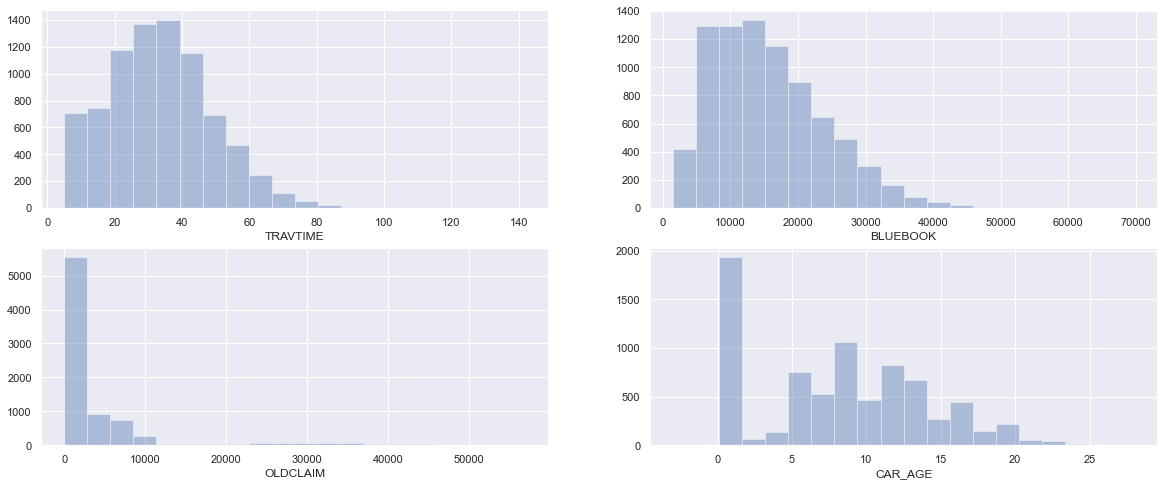

In [12]:
# some continuous features, directly related to the car/insurance
l=['TRAVTIME',
 'BLUEBOOK',
 'OLDCLAIM',
 'CAR_AGE']

fig, ax = plt.subplots(2,int(len(l)/2), figsize=(20,8))
ax = ax.ravel()

for i, col in enumerate(l):
    sns.distplot(data[col],kde=False, ax=ax[i], bins=20)

Most Traveling times range from 5 to 80, with the average being around 30 minutes. The bluebook value averages 15k: cheaper cars are concentrated around 7k-15k while more expensive ones are spread out all the way to 45k. 

The old claim distribution matches the old claim frequency explored before : most subjects do not have any claims and therefore an old claim value of 0. For those who do, the average value is around 5k. 

The majority of cars is 1 year and for older cars, most are under 11 years, with a high concentration around 6/7 years.

#### Bi-variate / Multi-variate study

After the general study of our features and labels, we start noticing relationships and patterns between features or between some features and the labels. Let's further explore these patterns. 

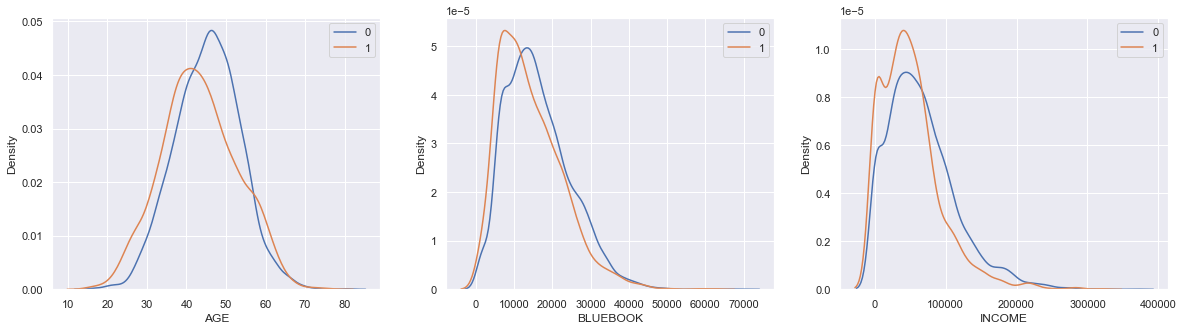

In [13]:
#some feature densities w.r.t TARGET_FLAG
f, ax = plt.subplots(1,3, figsize = (20,5))

sns.distplot(data.loc[data['TARGET_FLAG']==0]['AGE'], kde=True, hist=False, ax=ax[0] )
sns.distplot(data.loc[data['TARGET_FLAG']==1]['AGE'], kde=True, hist=False, ax=ax[0]  );
ax[0].legend(labels=['0','1'])

sns.distplot(data.loc[data['TARGET_FLAG']==0]['BLUEBOOK'], kde=True, hist=False, ax=ax[1]  )
sns.distplot(data.loc[data['TARGET_FLAG']==1]['BLUEBOOK'], kde=True, hist=False, ax=ax[1]  );
ax[1].legend(labels=['0','1'])

sns.distplot(data.loc[data['TARGET_FLAG']==0]['INCOME'], kde=True, hist=False, ax=ax[2] )
sns.distplot(data.loc[data['TARGET_FLAG']==1]['INCOME'], kde=True, hist=False, ax=ax[2] );
ax[2].legend(labels=['0','1']);



Concerning age, positive labels seem to be associated with younger subjects (orange curve shifted towards smaller ages). The orange curve's tail at the end indicates that older people also tend to be flagged as 1. This can support the claim that older/younger people tend to drive less safely than middle aged subejcts

Concerning the bluebook value, lower values are more associated with positive flags. Lower incomes exhibit the same behaviour. 


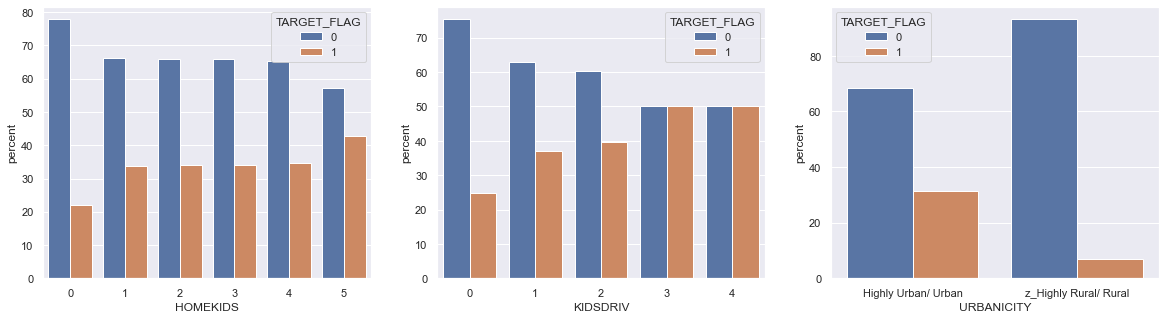

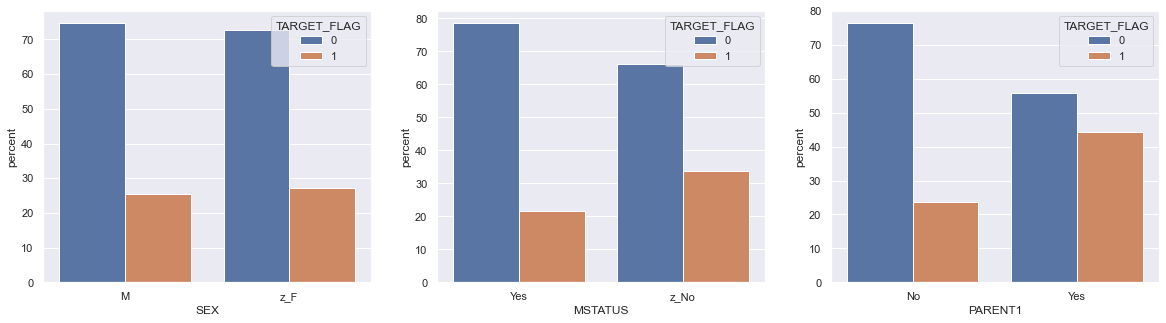

In [14]:
#some feature counts w.r.t TARGET_FLAG
f, ax = plt.subplots(1,3, figsize = (20,5))

sns.barplot(data=data.groupby('HOMEKIDS')['TARGET_FLAG'].value_counts(normalize=True).mul(100).rename('percent').reset_index(), x='HOMEKIDS',y='percent',hue='TARGET_FLAG', ax=ax[0])

sns.barplot(data=data.groupby('KIDSDRIV')['TARGET_FLAG'].value_counts(normalize=True).mul(100).rename('percent').reset_index(), x='KIDSDRIV',y='percent',hue='TARGET_FLAG', ax=ax[1])

sns.barplot(data=data.groupby('URBANICITY')['TARGET_FLAG'].value_counts(normalize=True).mul(100).rename('percent').reset_index(), x='URBANICITY',y='percent',hue='TARGET_FLAG', ax=ax[2]);

f, ax = plt.subplots(1,3, figsize = (20,5))
sns.barplot(data=data.groupby('SEX')['TARGET_FLAG'].value_counts(normalize=True).mul(100).rename('percent').reset_index(), x='SEX',y='percent',hue='TARGET_FLAG', ax=ax[0])
sns.barplot(data=data.groupby('MSTATUS')['TARGET_FLAG'].value_counts(normalize=True).mul(100).rename('percent').reset_index(), x='MSTATUS',y='percent',hue='TARGET_FLAG', ax=ax[1])
sns.barplot(data=data.groupby('PARENT1')['TARGET_FLAG'].value_counts(normalize=True).mul(100).rename('percent').reset_index(), x='PARENT1',y='percent',hue='TARGET_FLAG', ax=ax[2]);





Considering the fact that positive labels are only 26% of our data, when the above percentages are way smaller/bigger than ~25%,the feature can be a significant differenciation : this is the case for a big number of kids  (HOMEKIDS = 5), when the a large number of the kids drive (KIDSDRIV>2), when the subject lives in rural areas(Highly rural/Rural URBANICITY ) and they are a signle parent (PARENT1=True). 

For SEX and MSTATUS, there is no significant difference.


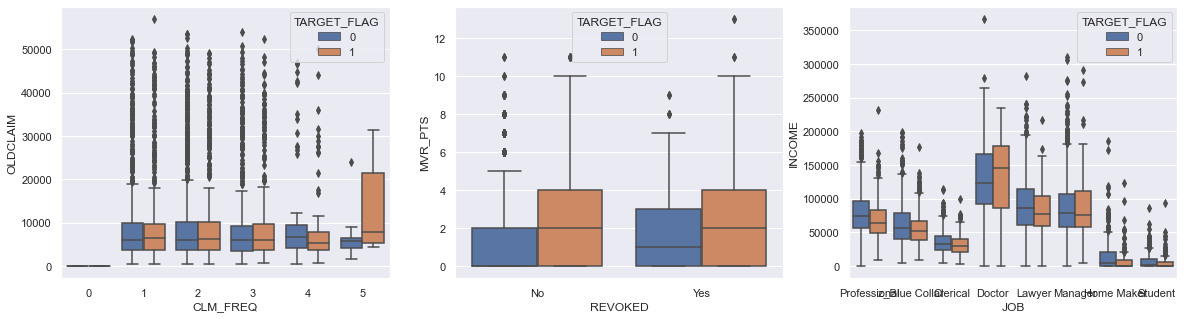

In [15]:
f, axes = plt.subplots(1,3, figsize = (20,5))

# Plot [0,0]
sns.boxplot(data = data, x = 'CLM_FREQ', y = 'OLDCLAIM', ax = axes[0], hue='TARGET_FLAG')

#although MVR points were considered categorical, since their values are multiple, we can draw a box plot
sns.boxplot(data = data, x = 'REVOKED', y = 'MVR_PTS', ax = axes[1], hue='TARGET_FLAG')

sns.boxplot(data = data, x = 'JOB', y = 'INCOME', ax = axes[2], hue='TARGET_FLAG');


Concerning claim frequency, there does not seem to be an important difference in the value of the claim, apart for when the frequency = 5, where the interquartile range as well as the max/min are much bigger for the positive flag. 


Positive flags have more MVR points, whether they've had their license revoked or not. Negative flags on the other hand, have higher average MVR Points than their non-revoked counterparts.

Subjects with average higher income are often flagged as negative, except for extremely high incomeswhere positive flags are similar (LAwyers/Managers) or more prevalent (Doctors) than negative flags. 

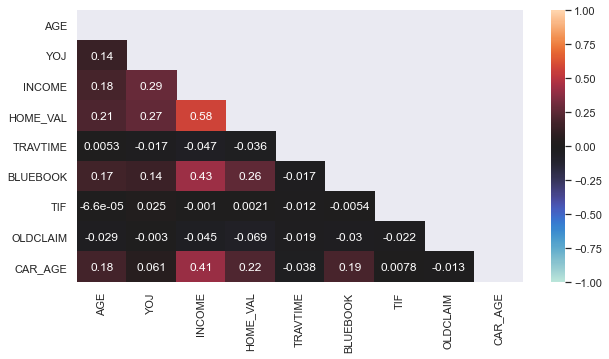

In [16]:
### correlation of continuous variables
corr_matrix=data[list(cols_cont)].corr(method='pearson')
plt.figure(figsize=(10,5))

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr_matrix, mask=mask,  center=0, vmax=1, vmin =-1, annot=True);

The most highly correlated features are INCOME and HOME_VAL and INCOME and BLUEBOOK. This is understandable as subjects with higher income will own more expensive homes and cars. Concerning the rest, there is no significant correlation between the rest of the features. 

#### Preprocessing

In [17]:
### one hot encoding of the categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
categorization = ColumnTransformer([
        ("cat", categorical_transformer, list(cols_cat.columns)) ,    
    ]
)

### scaling continuous 
scaler = ColumnTransformer([
        ("scaler", StandardScaler(), list(cols_cont.columns)) ,    
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("scaler", StandardScaler(), list(cols_cont.columns)) ,
       ("cat", categorical_transformer, list(cols_cat.columns)) 
    ]
)



In [18]:
#After one-hot encoding, original names of the features can be hard to retrieve 

def ohe_features_corresp(X_train, cols_cont):
    feat_col_correspondance={}
    d=0
    for i,c in enumerate(list(X_train.columns)):
        if c in cols_cont:
            feat_col_correspondance[c]='f{}'.format(d)
            d+=1
        else:
            cnt=X_train[c].value_counts()
            for idx in cnt.index:
                feat_col_correspondance[c+'_'+str(idx)]='f{}'.format(d)
                d+=1
    return feat_col_correspondance

#### Classification Pipeline

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df, data['TARGET_FLAG'], test_size=0.2, random_state=0)

In [20]:
### Comparison of all classifiers 

def try_classifiers(clfs, clfs_name, importance=False):
    
    f1_avg=[]
    f1_std=[]

    recall_avg=[]
    recall_std=[]

    feat_importance=[]


    for i,c in enumerate(clfs):

        ### fitting the classifier pipeline
        print('training with model {}'.format(clfs_name[i]))
        clf=Pipeline(steps=[("preprocessor", preprocessor), 
                   ('imputer',KNNImputer(n_neighbors=2)),
                   ("classifier", c)])
        clf.fit(X_train, y_train)

        if importance:
            try:
                feature_important = clf['classifier'].get_booster().get_score(importance_type='weight')
                keys = list(feature_important.keys())
                values = list(feature_important.values())
                imp = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
                feat_importance.append(imp)

            except AttributeError:
                pass

        ### scores of interest
        f1 = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1_macro' )
        f1_avg.append(np.mean(f1))
        f1_std.append(np.std(f1))

        recall = cross_val_score(clf, X_train, y_train, cv=5, scoring='recall')
        recall_avg.append(np.mean(recall))
        recall_std.append(np.std(recall))


    return f1_avg, f1_std, recall_avg, recall_std, feat_importance
    

In [21]:
#All the classifiers have been lightly finetuned, in order to compare best case scenarios for all of them

clfs = [LogisticRegression(C=1.5e2,penalty="l2"), LogisticRegression(C=1.5e2,penalty="l1", solver='saga'), 
        GradientBoostingClassifier(n_estimators=100, learning_rate=1,max_depth=1), 
        RandomForestClassifier(max_depth=None, random_state=0 ), 
        XGBClassifier(verbosity = 0)]
clfs_name=['RidgeLogReg','LassoLogReg', 'GBoost', 'RandForest', 'XGBoost']
f1_avg, f1_std, recall_avg, recall_std, _ = try_classifiers(clfs, clfs_name)


training with model RidgeLogReg
training with model LassoLogReg
training with model GBoost
training with model RandForest
training with model XGBoost


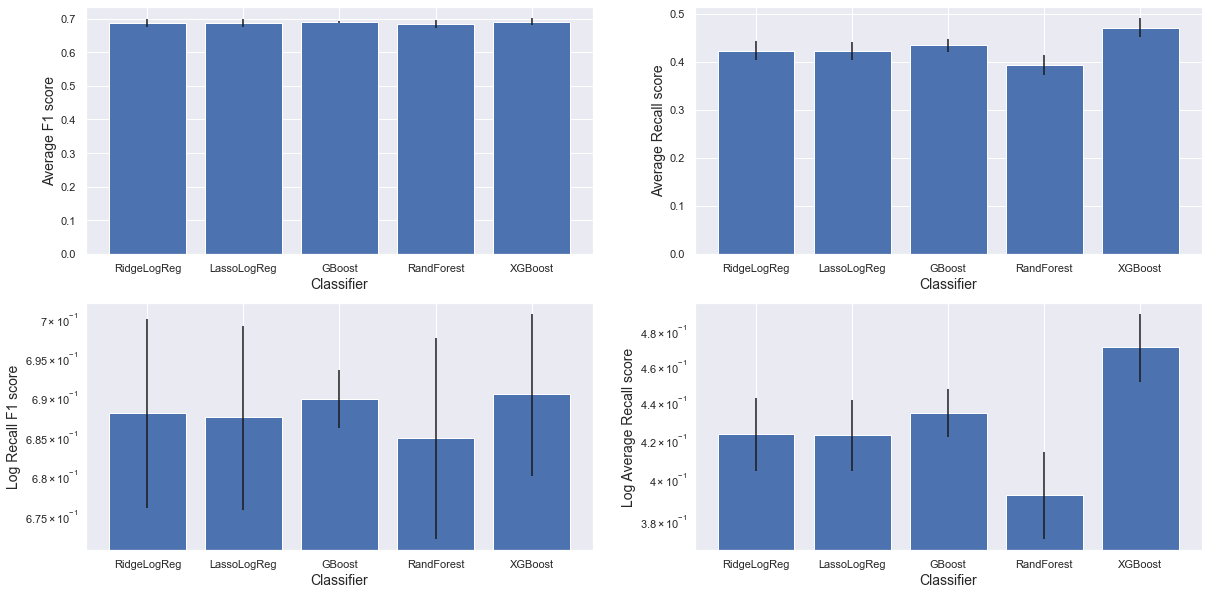

In [22]:
fig, ax = plt.subplots(2,2, figsize=(20,10))

ax[0,0].bar(clfs_name, f1_avg ,yerr=f1_std)
ax[0,0].set_xlabel("Classifier", fontsize=14);
ax[0,0].set_ylabel("Average F1 score", fontsize=14);

ax[0,1].bar(clfs_name, recall_avg,yerr=recall_std)
ax[0,1].set_xlabel("Classifier", fontsize=14);
ax[0,1].set_ylabel("Average Recall score", fontsize=14);

### since all results are extremely close, we use the log scale to better visualize the score differences. 
ax[1,0].set_yscale('log')
ax[1,0].bar(clfs_name, f1_avg ,yerr=f1_std)
ax[1,0].set_xlabel("Classifier", fontsize=14);
ax[1,0].set_ylabel("Log Recall F1 score", fontsize=14);

ax[1,1].set_yscale('log')
ax[1,1].bar(clfs_name, recall_avg,yerr=recall_std)
ax[1,1].set_xlabel("Classifier", fontsize=14);
ax[1,1].set_ylabel("Log Average Recall score", fontsize=14);

The macro F1 score is similar for all classifiers. When we look at the recall, we can see that XGBoost outperforms all other models. Since the positive class (predicting actual claims) can be considered to be more important, we will choose XGboost as our main classifier which we will try to adjust more.

In [23]:
### XGboost : balancing classes 
c = [ XGBClassifier(verbosity = 0), XGBClassifier(scale_pos_weight=74, verbosity = 0)]
c_name=['non_balanced', 'balanced']
     
f1_avg, f1_std, recall_avg, recall_std, feat_importance = try_classifiers(c, c_name, importance=True)


training with model non_balanced
training with model balanced


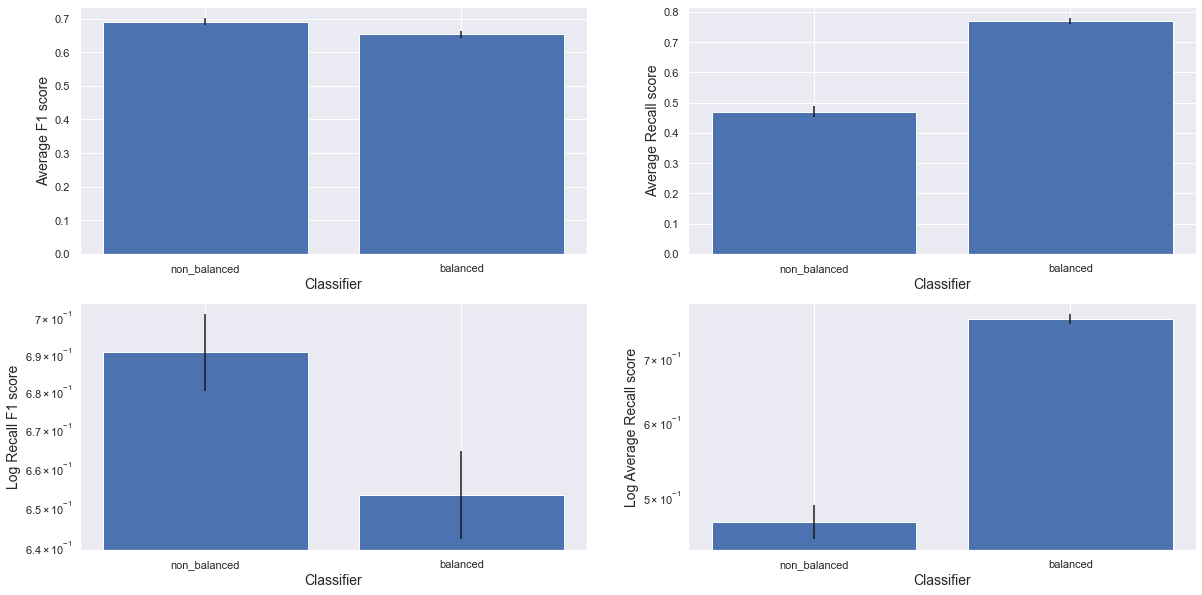

In [24]:
fig, ax = plt.subplots(2,2, figsize=(20,10))

ax[0,0].bar(c_name, f1_avg ,yerr=f1_std)
ax[0,0].set_xlabel("Classifier", fontsize=14);
ax[0,0].set_ylabel("Average F1 score", fontsize=14);

ax[0,1].bar(c_name, recall_avg,yerr=recall_std)
ax[0,1].set_xlabel("Classifier", fontsize=14);
ax[0,1].set_ylabel("Average Recall score", fontsize=14);

### since all results are extremely close, we use the log scale to better visualize the score differences. 
ax[1,0].set_yscale('log')
ax[1,0].bar(c_name, f1_avg ,yerr=f1_std)
ax[1,0].set_xlabel("Classifier", fontsize=14);
ax[1,0].set_ylabel("Log Recall F1 score", fontsize=14);

ax[1,1].set_yscale('log')
ax[1,1].bar(c_name, recall_avg,yerr=recall_std)
ax[1,1].set_xlabel("Classifier", fontsize=14);
ax[1,1].set_ylabel("Log Average Recall score", fontsize=14);

In [25]:
ftrs=ohe_features_corresp(X_train,cols_cont)
rev_ftrs= {v: k for k, v in ftrs.items()}
bal=feat_importance[1]
bal['name']=bal.index.map(rev_ftrs)

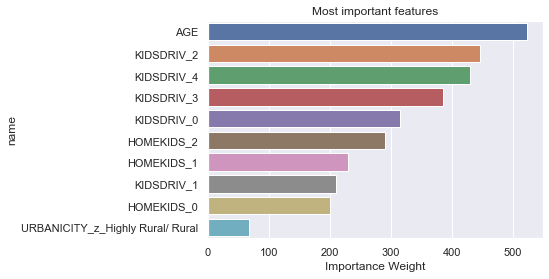

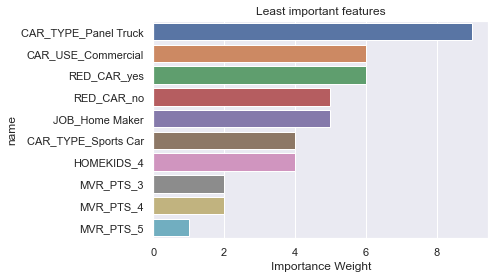

In [26]:
sns.barplot(bal['score'][:10].values, bal['name'][:10])
plt.title('Most important features')
plt.xlabel('Importance Weight')
plt.figure()
sns.barplot(bal['score'][-10:].values, bal['name'][-10:]);
plt.title('Least important features')
plt.xlabel('Importance Weight');

The age of the subject, kids who drive, number of kids as well as if region is Rural are the most important features for our classifier. On the other had, the classifier doesn't care for the type/color of car as well as the MVR points. 
Some of these results are in accordance with the analysis made earlier (AGE, KIDSDRIV, HOMEKIDS, URBANICITY)

In [27]:
### testing on our own test set 

clf = Pipeline(steps=[("preprocessor", preprocessor), 
                   ('imputer',KNNImputer(n_neighbors=2)),
                   ("classifier", XGBClassifier(scale_pos_weight=74, verbosity = 0))])
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
f1_test=f1_score(y_test, y_pred, 'macro')
recall_test = recall_score(y_test,y_pred)

In [28]:
print(f1_test, recall_test)

0.5414987912973409 0.7943262411347518


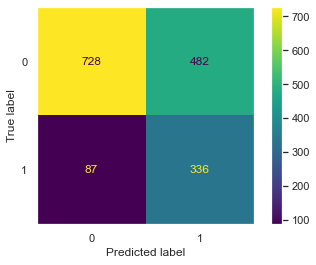

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

c=confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=c,display_labels=clf.classes_)
disp.plot()
plt.grid(False)
plt.show();

Balancing the classes in the model forces it to predict more positive labels. To a certain extent, this can be good for us, as most true labels are right (almost 80%). On the other hand, the f1 score remains low because there are more false positives. 

### Test

In [30]:
def predict(data_test, clf, proba=False):
    if proba : 
        data_test['TARGET_FLAG']=clf.predict_proba(data_test.iloc[:,2:])[:,1]
    else: 
        data_test['TARGET_FLAG']=clf.predict(data_test.iloc[:,2:])
    data_test['TARGET_FLAG'].to_csv('test_pred.csv')
    print('Predicted targets ! - file : test_pred.csv' )

In [31]:
predict(data_test,clf, proba=False)

Predicted targets ! - file : test_pred.csv
